### Tối ưu $\text{SNR}_o$
Đầu vào:
- $\text{SNR}_o = \frac{g^2 \left| \frac{Z_L}{Z_R + Z_L} \right|^2 \left| Z_{RT} \right|^2 S_{IT}}{N_{na} + g^2 \left| \frac{Z_R}{Z_R + Z_L} \right|^2 2kT \text{Re}(Z_L)}$
- $Re(Z_L) > 0, Re(Z_R) > 0, Ima(Z_L) \in \R, Ima(Z_R) \in \R $

Đầu ra: 
- $(\text{SNR}_o)_{max}$
- $Z_L, Z_R$

In [1]:
import numpy as np # type: ignore
import random
import copy
import matplotlib.pyplot as plt # type: ignore

In [2]:
# Khai báo hằng số
g = 10.0
Z_RT = 50 + 0j      # trở kháng truyền dẫn (phức)
S_IT = 1e-8          # công suất tín hiệu vào
N_na = 1e-8         # noise addition
k = 1.38e-23        # hằng số Boltzmann
T = 300             # nhiệt độ (Kelvin)


In [3]:
def cal_snr(Z_R, Z_L):
    num = (g**2) * abs(Z_L / (Z_R + Z_L))**2 * abs(Z_RT)**2 * S_IT
    denom = N_na + (g**2) * abs(Z_R / (Z_R + Z_L))**2 * 2 * k * T * Z_L.real
    return num / denom if denom != 0 else 0

In [4]:
alpha = N_na 
beta  = g**2 * 2 * k * T

Z_L = complex(alpha/beta + 1e12, alpha/beta + 1e12)
Z_R = complex(100, 0.1)

SNRo = cal_snr(Z_R, Z_L)
print(10*np.log10(SNRo))

limit_SNRo = (g**2 * abs(Z_RT)**2 * S_IT) / (alpha - alpha**2/(alpha + beta * Z_L.real))
print(10*np.log10(limit_SNRo))
                                             

53.97940008629084
54.030918422984755


In [5]:
class Problem:
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper
    
    def show_best(self):
        alpha = N_na 
        beta  = g**2 * 2 * k * T
        x = self.lower[2]
        y = self.upper[3]
        a = self.lower[0]
        b = - y * (alpha / (alpha + beta * x))
        
        Z_R = complex(a, b)
        Z_L = complex(x, y)
        print(f"Z_R = {Z_R}")
        print(f"Z_L = {Z_L}")
        SNRo = 10*np.log10(cal_snr(Z_R, Z_L))
        print(f"SNRo = {SNRo} (dB)")

        best_SNRo = 10*np.log10((g**2 * abs(Z_RT)**2 * S_IT) / (alpha - alpha**2/(alpha + beta * x)))
        print(f"limit SNRo = {best_SNRo} (dB)")


In [6]:
def decode(chromosome, problem: Problem):
    x = chromosome * (problem.upper - problem.lower) + problem.lower
    x = np.clip(x, problem.lower, problem.upper)
    return x

def get_fitness(solution):
    Z_R = complex(solution[0], solution[1])
    Z_L = complex(solution[2], solution[3])
    SNRo = cal_snr(Z_R, Z_L)
    return 10 * np.log10(SNRo)

In [7]:
class Individual:
    def __init__(self):
        self.chromosome = None
        self.fitness = None

    def genIndi(self):
        self.chromosome = np.random.uniform(0.0, 1.0, 4)
    
    def cal_fitness(self, problem):
        solution = decode(self.chromosome, problem)
        self.fitness = get_fitness(solution)

    def clone(self):
        return copy.deepcopy(self)
    
    def __repr__(self):
        return f"chromosome={self.chromosome}, fitness={self.fitness:.2f})"

In [8]:
# Simulated binary crossover - SBX
def crossover(parent1, parent2, problem : Problem, eta = 2.0):
    off1 = Individual()
    off2 = Individual()
    r = np.random.rand()
    if (r <= 0.5):
        beta = (2*r)**(1.0/(eta + 1))
    else:
        beta = (1.0/(2*(1 - r)))**(1.0/(eta + 1))
    p1 = parent1.chromosome
    p2 = parent2.chromosome
    c1 = 0.5 * ((1 + beta) * p1 + (1 - beta) * p2)
    c2 = 0.5 * ((1 - beta) * p1 + (1 + beta) * p2)
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    off1.chromosome = c1
    off2.chromosome = c2
    return off1.clone(), off2.clone()


In [9]:

# Polynomial mutaion - PM
def mutation(indi : Individual, eta = 20.0):
    chr = indi.chromosome
    for i in range(chr.size):
        mu = np.random.rand()
        if (mu <= 0.5):
            delta = (2 * mu)**(1.0/(1 + eta)) - 1
            chr[i] = chr[i] + delta * chr[i]
        else:
            delta = 1 - (2 - 2*mu)**(1.0/(1 + eta))
            chr[i] = chr[i] + delta * (1 - chr[i])
            
    chr = np.clip(chr, 0.0, 1.0)
    indi.chromosome = chr
    return indi.clone()

In [10]:
class Population:
    def __init__(self, pop_size, problem : Problem):
        self.pop_size = pop_size
        self.list_indi = []
        self.problem = problem
    
    def genPop(self):
        for i in range(self.pop_size):
            indi = Individual()
            indi.genIndi()
            indi.cal_fitness(self.problem)
            self.list_indi.append(indi)

    def show(self):
        for i in range(len(self.list_indi)):
            print(f"Individual {i}: {self.list_indi[i]}")


In [11]:
def selection(list, k = 2):
    tour1 = random.sample(list, k)
    tour2 = random.sample(list, k)
    x = max(tour1, key=lambda indi: indi.fitness)
    y = max(tour2, key=lambda indi: indi.fitness)
    return x.clone(), y.clone() 

In [12]:
def survival_selection(list, pop_size):
    list = sorted(list, key=lambda indi: indi.fitness, reverse=True)
    list = list[0: pop_size]
    return list

In [13]:
def GA(problem, pop_size, max_gen, p_c, p_m):
    pop = Population(pop_size, problem)
    pop.genPop()
    history = []
    for i in range(max_gen):
        child = []
        while (len(child) < pop_size):
            p1, p2 = selection(pop.list_indi)
            if np.random.rand() <= p_c:
                c1, c2 = crossover(p1, p2, problem)
                c1.cal_fitness(problem)
                c2.cal_fitness(problem)
                child.append(c1)
                child.append(c2)
            if np.random.rand() <= p_m:
                p1 = mutation(p1)
                p2 = mutation(p2)
                p1.cal_fitness(problem)
                p2.cal_fitness(problem)
                child.append(p1)
                child.append(p2)
        pop.list_indi = survival_selection(pop.list_indi + child, pop_size)
        history.append(pop.list_indi[0].fitness)
    solution = pop.list_indi[0]
    return history, solution


In [14]:
# setup
#                 ReZR  ImaZR  ReZL  ImaZL
upper = np.array([1500, 1500, 1e12, 1500])
lower = np.array([  10,-1500, 1e10,-1500])
problem = Problem(lower, upper)

#                 ReZR  ImaZR  ReZL  ImaZL
# upper = np.array([1500, 1500, 1500, 1500])
# lower = np.array([  10,-1500,   10,-1500])
# problem = Problem(lower, upper)

pop_size = 20
max_gen = 10000
Pc = 0.9
Pm = 0.2

# start
fitness_history, best_indi = GA(problem, pop_size, max_gen, Pc, Pm)

#show
for i in range(len(fitness_history)):
    print(f"Generation {i}, best fitness = {fitness_history[i]}")

Generation 0, best fitness = 53.97940008594077
Generation 1, best fitness = 53.97940008630278
Generation 2, best fitness = 53.97940008630278
Generation 3, best fitness = 53.97940008635463
Generation 4, best fitness = 53.97940008644193
Generation 5, best fitness = 53.97940008644193
Generation 6, best fitness = 53.979400086459464
Generation 7, best fitness = 53.97940008646644
Generation 8, best fitness = 53.97940008646644
Generation 9, best fitness = 53.979400086471244
Generation 10, best fitness = 53.979400086483
Generation 11, best fitness = 53.97940008648312
Generation 12, best fitness = 53.97940008649907
Generation 13, best fitness = 53.9794000865076
Generation 14, best fitness = 53.97940008651646
Generation 15, best fitness = 53.979400086522624
Generation 16, best fitness = 53.97940008653169
Generation 17, best fitness = 53.97940008653339
Generation 18, best fitness = 53.979400086534724
Generation 19, best fitness = 53.97940008653491
Generation 20, best fitness = 53.97940008653837
G

In [15]:
# np.set_printoptions(precision=2, suppress=True)
print("solution:")
solution = decode(best_indi.chromosome, problem)
Z_R = complex(solution[0], solution[1])
Z_L = complex(solution[2], solution[3])
print(f"Z_R = {Z_R}")
print(f"Z_L = {Z_L}")
print(f"SNRo = {best_indi.fitness} (dB)")
print("====")
problem.show_best()

solution:
Z_R = (10-1500j)
Z_L = (1000000000000+1500j)
SNRo = 53.97940008663352 (dB)
====
Z_R = (10-820.5689277899343j)
Z_L = (10000000000+1500j)
SNRo = 53.979400078034544 (dB)
limit SNRo = 57.418858632849705 (dB)


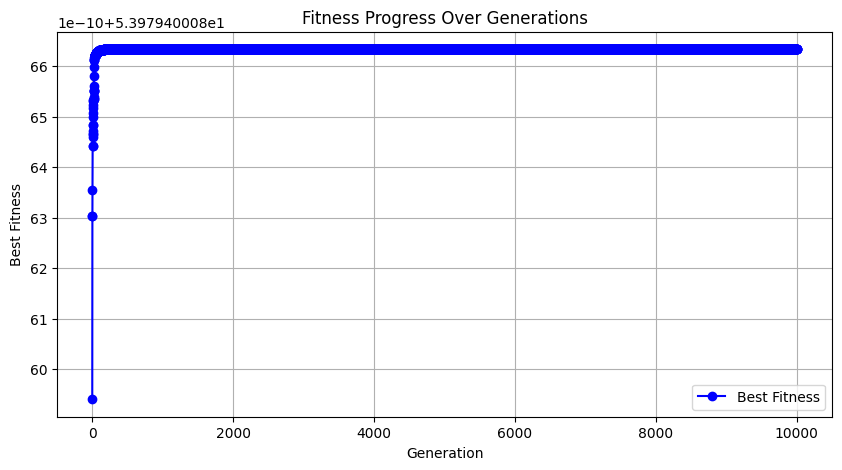

In [16]:
generations = list(range(len(fitness_history)))
plt.figure(figsize=(10, 5))
plt.plot(generations, fitness_history, marker='o', linestyle='-', color='b', label='Best Fitness')

plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Fitness Progress Over Generations")
plt.legend()
plt.grid(True)
plt.show()